In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
combined_data = pd.read_csv('data/combined_data/cleaned_data.csv')

In [3]:
combined_data.head()

,T,TM,Tm,H,PP,VV,V,VM,PM_2_5
0,21.0,27.6,14.6,61.0,0.0,6.0,2.2,3.5,284.795833
1,21.6,27.7,17.0,59.0,0.0,6.8,2.0,3.5,239.695455
2,22.3,29.0,16.1,48.0,0.0,6.9,2.8,3.5,182.187500
3,20.9,29.0,16.0,66.0,0.0,5.5,2.2,3.5,264.064286
4,20.9,27.8,16.0,62.0,0.0,6.3,3.0,5.4,223.208333


In [4]:
X = combined_data.iloc[:, :-1]
y = combined_data.iloc[:, -1]

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

## XGBOOST REGRESSOR

In [7]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [8]:
f'Coefficient of determination R^2 on train set {xgb.score(X_train, y_train)}'
# must be close to 1, 1 is perfect fit

'Coefficient of determination R^2 on train set 0.997025741986252'

In [9]:
f'Coefficient of determination R^2 on test set {xgb.score(X_test, y_test)}'

'Coefficient of determination R^2 on test set 0.3443862029175001'

In [10]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(xgb, X, y, cv = 3)

In [11]:
score.mean()

0.22294918533881458

In [12]:
pred = xgb.predict(X_test)

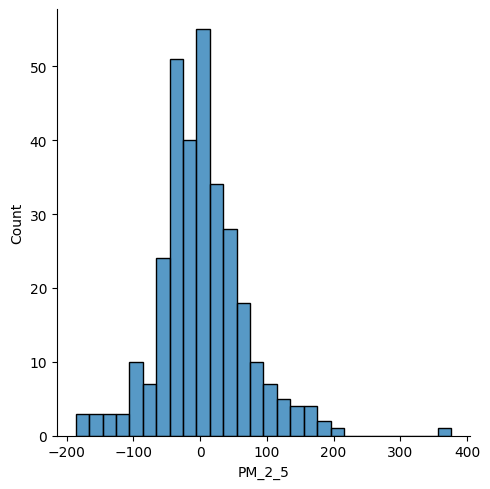

In [14]:
sns.displot(y_test - pred)

#### HYPERPARAMETER TUNING

In [15]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=1200, num=12)]
learning_rate = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
max_depth = [int(x) for x in np.linspace(5, 30, num=6)]
subsample = [0.7, 0.6, 0.8]
min_child_weight = list(range(3, 8))
objective = ['reg:squarederror']
params = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'max_depth': max_depth,
    'subsample': subsample,
    'min_child_weight': min_child_weight,
    'objective': objective
}

In [16]:
from sklearn.model_selection import RandomizedSearchCV
search = RandomizedSearchCV(xgb, params, scoring='neg_mean_squared_error', 
                            cv=5, n_iter=100, random_state=43, n_jobs=-1, verbose=True)
search.fit(X,y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          predictor=None, random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.4, 0.5, 0.6],
                                        'max_depth': [5, 10, 15, 20, 25, 30],
                                        'min_child_weight': [3, 4, 5, 6, 7],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200],
                                        'objective': ['reg:squarederror'],
                                        'subsample': [0.7, 0.6, 0.8]},
                   random_state=43, scoring='neg_mean_squared_error',
                   verbose=True)

In [17]:
search.best_params_

{'subsample': 0.8,
 'objective': 'reg:squarederror',
 'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 20,
 'learning_rate': 0.05}

In [18]:
search.best_score_

-4966.889106802274

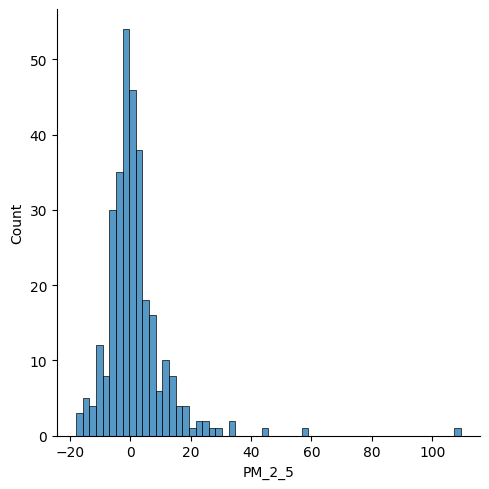

In [19]:
pred = search.predict(X_test)
sns.displot(y_test-pred)

In [20]:
from sklearn import metrics
print(f"Mean Abs Error: {metrics.mean_absolute_error(y_test, pred)}")
print(f"Mean Sq Error: {metrics.mean_squared_error(y_test, pred)}")
print(f"Root Mean Error: {np.sqrt(metrics.mean_squared_error(y_test, pred))}")

Mean Abs Error: 6.291338952499295
Mean Sq Error: 119.15529059108162
Root Mean Error: 10.915827526627636


In [21]:
search.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [22]:
import pickle
pickle.dump(search, open('xgb.pkl', 'wb'))